# Beginners guide to data engineering - Part I

## The Hierachy of Analytics 

*Think of Artificial Intelligence as the top of a pyramid of needs. Yes, self-actualization (AI) is great, but you first need food, water, and shelter (data literacy, collection, and infrastructure).*

** Use the bottom up approch **

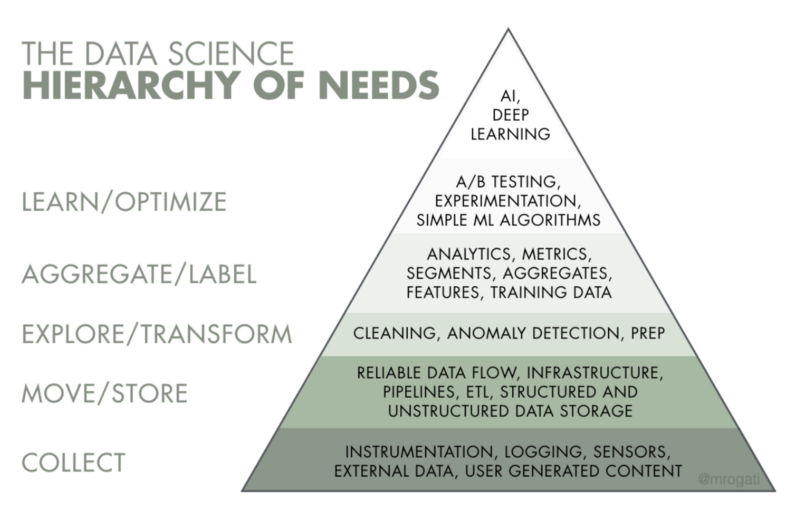

## What is data engineering 

*Data engineering field could be thought of as a superset of business intelligence and data warehousing that brings more elements from software engineering. This discipline also integrates specialization around the operation of so called “big data” distributed systems, along with concepts around the extended Hadoop ecosystem, stream processing, and in computation at scale.*

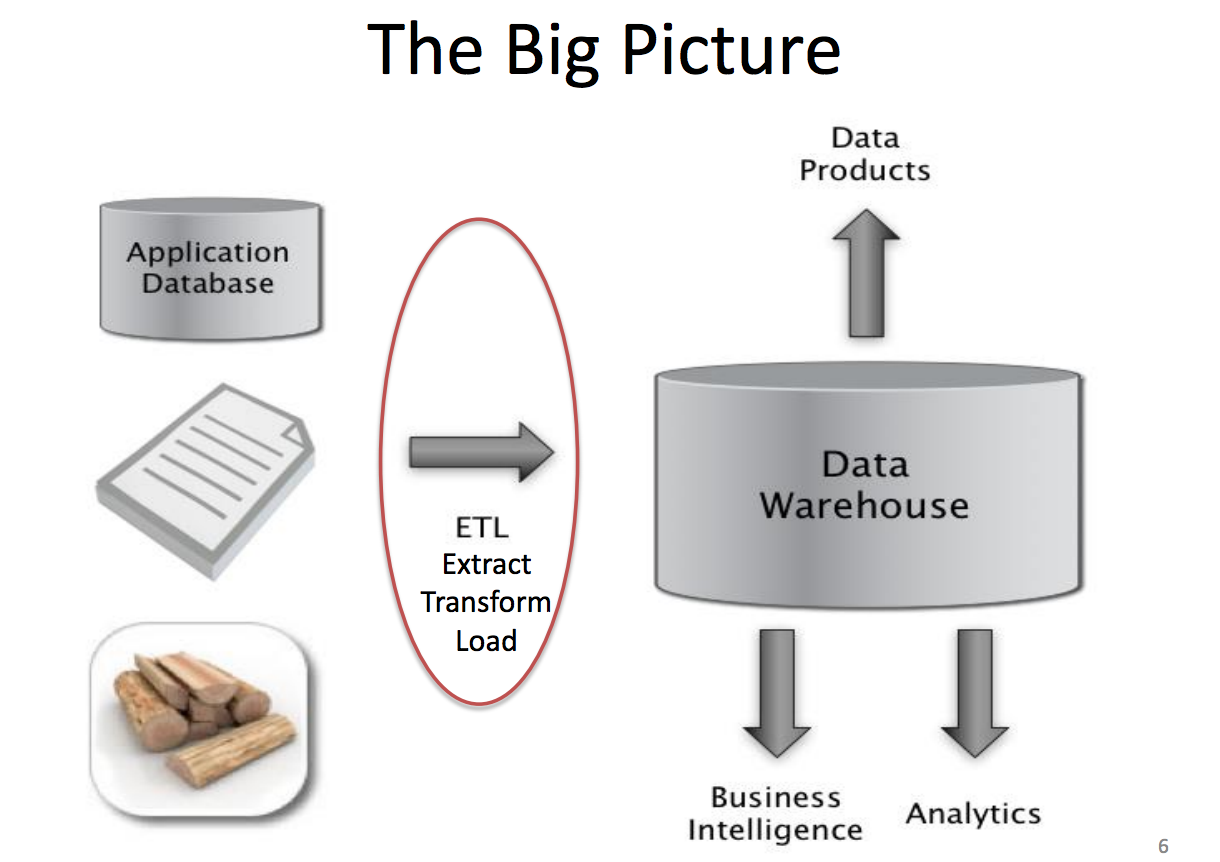

## ETL: Extract, Transform and Load

ETL, which stands for Extract, Transform, and Load. These three conceptual steps are how most data pipelines are designed and structured. They serve as a blueprint for how raw data is transformed to analysis-ready data.

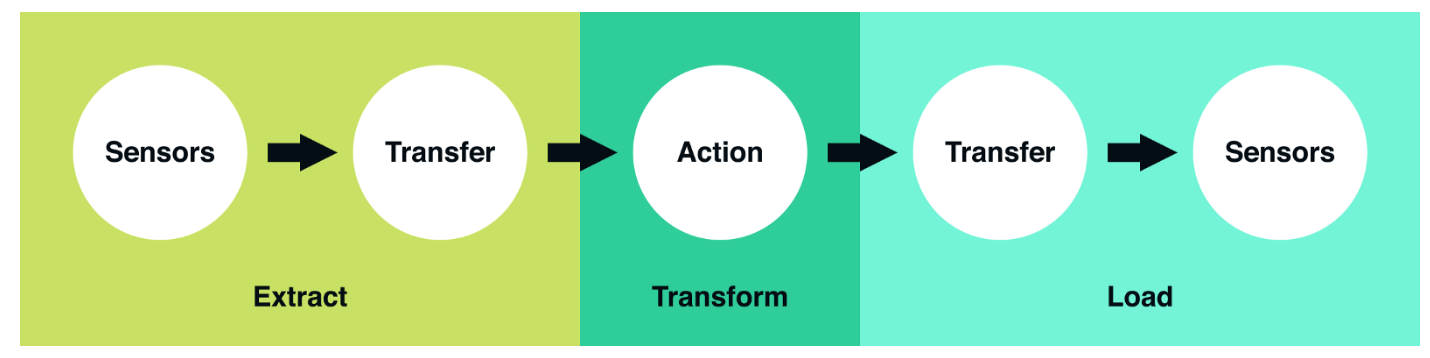

**Extract**: this is the step where sensors wait for upstream data sources to land (e.g. a upstream source could be machine or user-generated logs, relational database copy, external dataset … etc). Upon available, we transport the data from their source locations to further transformations.

**Transform**: This is the heart of any ETL job, where we apply business logic and perform actions such as filtering, grouping, and aggregation to translate raw data into analysis-ready datasets. This step requires a great deal of business understanding and domain knowledge.

**Load**: Finally, we load the processed data and transport them to a final destination. Often, this dataset can be either consumed directly by end-users or it can be treated as yet another upstream dependency to another ETL job, forming the so called data lineage

## Choosing ETL Framework

**Configuration**: ETLs are naturally complex, and we need to be able to succinctly describe the data flow of a data pipeline. As a result, it is important to evaluate how ETLs are authored. Is it configured on a UI, a domain specific language, or code? Nowadays, the concept of configuration as code is gaining popularity, because it allows users to expressively build pipelines programmatically that are customizable.

**UI, Monitoring, Alerts**: Long running batch processes inevitably can run into errors (e.g. cluster failures) even when the job itself does not have bugs. As a result, monitoring and alerting are crucial in tracking the progress of long running processes. How well does a framework provide visual information for job progress? Does it surface alerts or warnings in a timely and accurate manner?

**Backfilling**: Once a data pipeline built, we often need to go back in time and re-process the historical data. Ideally, we do not want to build two separate jobs, one for backfilling historical data and another for computing current or future metrics. How easy does a framework support backfilling? Can it do so in a way that is standardized, efficient, and scalable? All these are important questions to consider.

## Two Paradigms : SQL-Centric vs JVM-Centric ETL

**JVM-centric ETL**: Is typically built in a JVM-based language (like Java or Scala). Engineering data pipelines in these JVM languages often involves thinking data transformation in a more imperative manner, e.g. in terms of key-value pairs. Writing User Defined Functions (UDFs) are less painful because one does not need to write them in a different language, and testing jobs can be easier for the same reason. This paradigm is quite popular among engineers.

**SQL-centric ETL**: Is typically built in languages like SQL, Presto, or Hive. ETL jobs are often defined in a declarative way, and almost everything centers around SQL and tables. Writing UDFs sometimes is troublesome because one has to write it in a different language (e.g. Java or Python), and testing can be a lot more challenging due to this. This paradigm is popular among data scientists.

**SQL-centric ETL way tends to ease up data engineering understanding**

# Beginners guide to data engineering - Part II

## Data Modeling

*A design process where one carefully defines table schemas and data relations to capture business metrics and dimensions.*

#### Online transaction processing (OLTP)

A good example of the OLTP would be a website were user have their profile stored and they want to gain access to it.



*In order to serve them accurately and on time to users, it is critical to optimize the production databases for **online transaction processing (OLTP)***

#### Online analytical processing system (OLAP)

The designer need to focus on insight generation, meaning analytical reasoning can be translated into queries easily and statistics can be computed efficiently. This analytics-first approach often involves a design process called data modeling

### Data Modeling, Normalization, and Star Schema

Design decision could be to which extent should we normalize table in the databases

Normalization implies simpler schemas, more standardized data, and carry less redundancy which mean querying pattern will be more complex

Much easier to query on a denormalized table (joint), data processing for large table is sloweer and involves more upstream dependencies.This makes maintenance of ETL Pipeline more difficult.

**The star schema is a data design patterns in which tables are in a star-like pattern.**


### The star schema

Focus on building normalized tables, specifically fact and dimensions tables. When needed, denormalized tables can be built from thes smaller normalized tables. The design strives for a balance between ETL maintainability and ease of analytics.

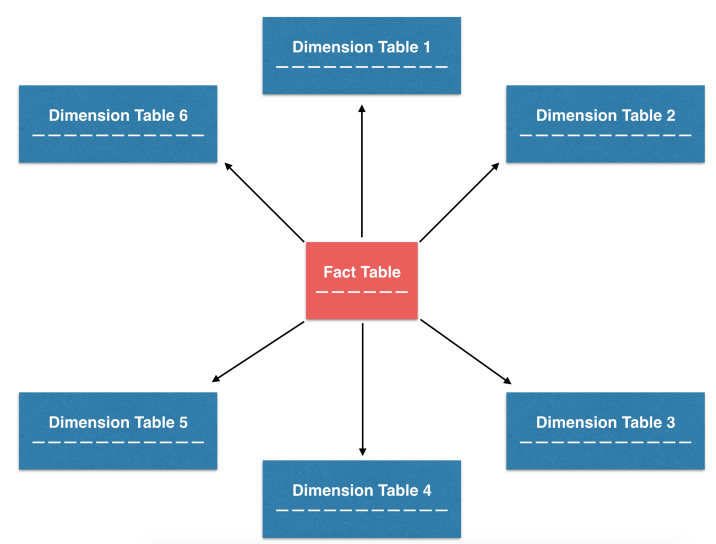

### Facts & Dimension Tables

**Fact tables** typically contain point-in-time transactional data. **Each row in the table can be extremely simple and is often represented as a unit of transaction**. Because of their simplicity, **they are often the source of truth tables from which business metrics are derived**. For example, at Airbnb, we have various fact tables that track transaction-like events such as bookings, reservations, alterations, cancellations, and more.

**Dimension tables** typically contain slowly changing attributes of specific entities, and attributes sometimes can be organized in a hierarchical structure. These attributes are often called “dimensions”, and can be joined with the fact tables, as long as there is a foreign key available in the fact table. At Airbnb, we built various dimension tables such as users, listings, and markets that help us to slice and dice our data.

## Data Partitioning

*A practice that enables more efficient querying and data backfilling*

### Data partitioning by datestamp

 In addition to following SQL best practices such as “filter early and often”, “project only the fields that are needed”, one of the most effective techniques to improve query performance is to partition data.

** Main idea: Instead of storing all the data in one chunck, we break it up into independent, self-contained chunks. Data from the same chunk will be assigned to the same partition key, which means that any subset of the data can be lokked up extremely quickly.This technique can greatly improve query perfomance. **

One common partition key is datestamp (ds for short) because:
* ETL jobs are base on datestamp
* Many analytical questions involve counting events that occured in a specific time range

### Backfilling Historical Data

Using datestamp as partition key ease backfiling of data (Usefull to revisit the historical trends and movements)

** Backfilling is so common that Hive built in the functionality of dynamic partitions, a construct that perform the same SQL operations over many partitions and perform multiple insertions at once **

 The beauty of dynamic partitions is that we wrap all the same work that is needed with a GROUP BY ds and insert the results into the relevant ds partitions all at once. This query pattern is very powerful and is used by many of Airbnb’s data pipelines. In a later section, I will demonstrate how one can write an Airflow job that incorporates backfilling logic using Jinja control flow.

## The Anatomy of an Airflow Pipeline

### Defining the Directed Acyclic Graph (DAG)

* In real life ETL jobs are often complex, consisting of many combinations of E,T,L Task
* **Visualization of the data flow using graph is often usefull**

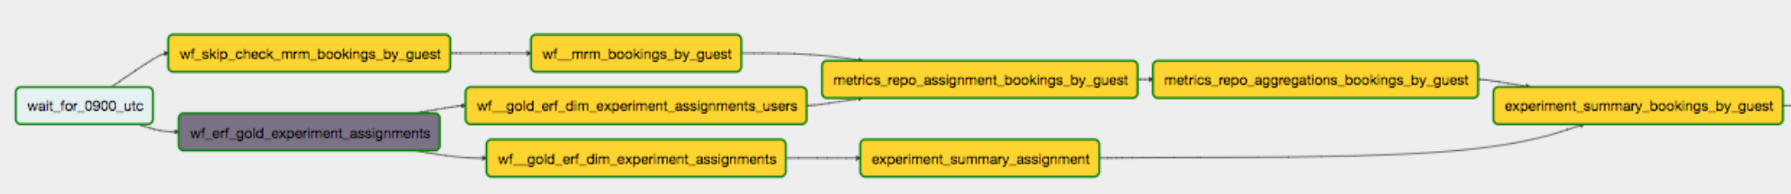

**DAGs describe how to run data pipeline.**

* **Node**: Represent a task
* **Arrow**: Represent a dependency on another task

A nice feature of Airflow is **Code as Configuration** (This graph is a representation of the code)


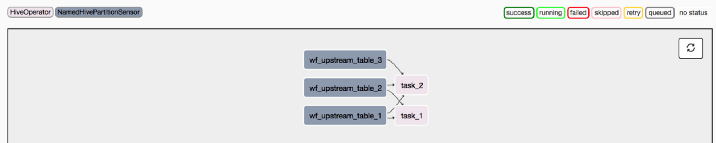

### Operators: Sensors, Operators and Transfer

***Operators describe what to do in a data pipeline.***

**Sensors**: waits for a certain time, external file, or upstream data source

* Unblock the data flow after a certain time, or after data source become available ex:**NamedHivePartitionSensors**


**Operators**: triggers a certain action (e.g. run a bash command, execute a python function, or execute a Hive query, etc)

* Trigger data transformation ex: **HiveOperator**, **BashOperator**, **PythonOperator**

**Transfers**: moves data from one location to another

* ex: **MySqlToHiveTransfer**, **S3ToHiveTransfer**

### A simple example

In [ ]:
"""
A DAG docstring might be a good way to explain at a high level
what problem space the DAG is looking at.
Links to design documents, upstream dependencies etc
are highly recommended.
"""
from datetime import datetime, timedelta
from airflow.models import DAG  # Import the DAG class
from airflow.operators.sensors import NamedHivePartitionSensor
from airflow.operators.hive_operator import HiveOperator

### You can import more operators as you see fit!
# from airflow.operators.bash_operator import BashOperator
# from airflow.operators.python_operator import PythonOperator

# setting some default arguments for the DAG
default_args = {
    'owner': 'you',
    'depends_on_past': False,
    'start_date': datetime(2018, 2, 9),
}

# Instantiate the Airflow DAG
dag = DAG(
    dag_id='anatomy_of_a_dag',
    description="This describes my DAG",
    default_args=default_args,
    schedule_interval=timedelta(days=1))   # This is a daily DAG.

# Put upstream dependencies in a dictionary
wf_dependencies = {
    'wf_upstream_table_1': 'upstream_table_1/ds={{ ds }}',
    'wf_upstream_table_2': 'upstream_table_2/ds={{ ds }}',
    'wf_upstream_table_3': 'upstream_table_3/ds={{ ds }}',
}

# Define the sensors for upstream dependencies
for wf_task_id, partition_name in wf_dependencies.iteritems():
    NamedHivePartitionSensor(
        task_id=wf_task_id,
        partition_names=[partition_name],
        dag=dag
    )

# Put the tasks in a list
tasks = [
    ('hql', 'task_1'),
    ('hql', 'task_2'),
]

# Define the operators in the list above
for directory, task_name in tasks:
    HiveOperator(
        task_id=task_name,
        hql='{0}/{1}.hql'.format(directory, task_name),
        dag=dag,
    )

# Put the dependencies in a map
deps = {
    'task_1': [
        'wf_upstream_table_1',
        'wf_upstream_table_2',
    ],
    'task_2': [
        'wf_upstream_table_1',
        'wf_upstream_table_2',
        'wf_upstream_table_3',
    ],
}

# Explicitly define the dependencies in the DAG
for downstream, upstream_list in deps.iteritems():
    for upstream in upstream_list:
        dag.set_dependency(upstream, downstream)

## ETL Best Practices

 **Partition Data Tables** : Data partitioning can be especially useful when dealing with large-size tables with a long history. When data is partitioned using datestamps, we can leverage dynamic partitions to parallelize backfilling.

In [ ]:
CREATE TABLE IF NOT EXISTS fct_bookings (
    id_listing BIGINT COMMENT 'Unique ID of the listing'
  , id_host    BIGINT COMMENT 'Unique ID of the host who owns the listing'
  , m_bookings BIGINT COMMENT 'Denoted 1 if a booking transaction occurred'
)
PARTITION BY ( -- this is how we define partition keys
  ds STRING
);

**Load Data Incrementally** : Make your ETL more modular and manageable, especially when building dimension tables from the fact tables. In each run, we only need to append the new transactions to the dimension table from previous date partition instead of scanning the entire fact history.

In [ ]:
- Not Recommended Approach: Scan the entire table and rebuild everyday
INSERT OVERWRITE TABLE dim_total_bookings PARTITION (ds = '{{ ds }}')
SELECT
     dim_market
  ,  SUM(m_bookings) AS m_bookings
FROM
  fct_bookings
WHERE
  ds <= '{{ ds }}' -- this is expensive, and can quickly run into scale issue
GROUP BY
  dim_market
;

-- Recommended Approach: Incremental Load
INSERT OVERWRITE TABLE dim_total_bookings PARTITION (ds = '{{ ds }}')
SELECT
    dim_market
  , SUM(m_bookings) AS m_bookings
FROM (
  SELECT
      dim_market
    , m_bookings
  FROM
    dim_total_bookings            -- a dim table
  WHERE
    ds = DATE_SUB('{{ ds }}', 1)  -- from the previous ds

  UNION
  
  SELECT
      dim_market
    , SUM(m_bookings) AS m_bookings
  FROM
    fct_bookings                  -- a fct table
  WHERE
    ds = '{{ ds }}'               -- from the current ds
  GROUP BY
     dim_market
) a
GROUP BY
  dim_market
;

**Enforce Idempotency** : Many data scientists rely on point-in-time snapshots to perform historical analysis. This means the underlying source table should not be mutable as time progresses, otherwise we would get a different answer. Pipeline should be built so that the same query, when run against the same business logic and time range, returns the same result. This property has a fancy name called Idempotency.

**Parameterize Workflow**: Just like how templates greatly simplified the organization of HTML pages, Jinja can be used in conjunction with SQL. As we mentioned earlier, one common usage of Jinja template is to incorporate the backfilling logic into a typical Hive query. Stitch Fix has a very nice post that summarized how they use this technique for their ETL. https://multithreaded.stitchfix.com/blog/2017/07/06/one-weird-trick/

In [ ]:
{%- if backfill %}
INSERT OVERWRITE TABLE bookings_summary PARTITION (ds)
{%- else %}
INSERT OVERWRITE TABLE bookings_summary PARTITION (ds = '{{ ds }}')
{%- endif %}
SELECT
    dim_market
  , SUM(m_bookings) AS m_bookings
  {%- if backfill %}
  , ds
  {%- endif %}
FROM
  fct_bookings
WHERE
{%- if backfill %}
  ds BETWEEN '{{ start_date }}' AND '{{ end_date }}'
{%- else %}
  ds = '{{ ds }}'
{%- endif %}
GROUP BY
    dim_market
{%- if backfill %}
  , ds
{%- endif %}
;

**Add Data Checks Early and Often**: When processing data, it is useful to write data into a staging table, check the data quality, and only then exchange the staging table with the final production table. At Airbnb, we call this the **stage-check-exchange paradigm**. Checks in this 3-step paradigm are important defensive mechanisms — they can be simple checks such as counting if the total number of records is greater than 0 or something as complex as an anomaly detection system that checks for unseen categories or outliers.

In [ ]:
# Define the CREATE TABLE statement here
{%- macro create_table() %}
...
{%- endmacro %}

# Main ETL logic, insert the results into a STAGING table
{%- macro main() %}
...
{%- endmacro %}

# A series of simple presto CHECKS on the staging table
{%- macro health_checks() %}
...
{%- endmacro %}

# Finally, EXCHANGE the staging table with the prod table

**Build Useful Alerts & Monitoring System** : Since ETL jobs can often take a long time to run, it’s useful to **add alerts and monitoring** to them so we do not have to keep an eye on the progress of the DAG constantly. Different companies monitor DAGs in many creative ways — at Airbnb, we regularly use EmailOperators to send alert emails for jobs missing SLAs. Other teams have used alerts to flag experiment imbalances. Yet another interesting example is from Zymergen where they report model performance metrics such as R-squared with a SlackOperator.

** Best ETL Practices by Maxime Beauchemin **: https://www.youtube.com/watch?v=dgaoqOZlvEA&feature=youtu.be

# Beginners guide to data engineering - Part III

## TDB

# Source 

* https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7
* https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-ii-47c4e7cbda71


## Other Source


 * https://gtoonstra.github.io/etl-with-airflow/principles.html